In [35]:
import pandas as pd
import plotly.graph_objects as go
import warnings
from statsmodels.graphics import tsaplots
from utils import extractData_fromMariaDb
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

### Load data

In [12]:
df_agg = extractData_fromMariaDb()
df_agg.head()

,ds,y
0,2015-01-02,639.162270
1,2015-01-05,641.555843
2,2015-01-06,627.111015
3,2015-01-07,636.623308
4,2015-01-08,645.458136


In [13]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2153 entries, 0 to 2152
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2153 non-null   datetime64[ns]
 1   y       2153 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 50.5 KB


### Exploratory and clean data

In [14]:
### Visualizamos los datos y también añadimos bandas para detectar outliers
df_agg["SMA_30"] = df_agg["y"].rolling(window=30).mean()
df_agg["STD_30"] = df_agg["y"].rolling(window=30).std()


df_agg["Upper_Band"] = df_agg["SMA_30"] + (df_agg["STD_30"] * 3)
df_agg["Lower_Band"] = df_agg["SMA_30"] - (df_agg["STD_30"] * 3)

df_agg["Outlier"] = (df_agg["y"] > df_agg["Upper_Band"]) | (df_agg["y"] < df_agg["Lower_Band"])

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_agg["ds"], y=df_agg["y"], mode='lines', name='Datos originales'))
fig.add_trace(go.Scatter(x=df_agg["ds"], y=df_agg["SMA_30"], mode='lines', name='SMA 30 días'))

fig.add_trace(go.Scatter(
    x=pd.concat([df_agg["ds"], df_agg["ds"][::-1]]), 
    y=pd.concat([df_agg["Upper_Band"], df_agg["Lower_Band"][::-1]]),
    fill='toself',
    fillcolor='rgba(0, 176, 246, 0.3)',  
    line=dict(color='rgba(255,255,255,0)'),
    name='Bandas',
    showlegend=False
))


fig.add_trace(go.Scatter(
    x=df_agg[df_agg["Outlier"]]["ds"], 
    y=df_agg[df_agg["Outlier"]]["y"], 
    mode='markers', 
    marker=dict(color='red', size=6),
    name='Outliers'
))


fig.update_layout(
    title='Medias Móviles y Bandas de Desviación Estándar (30 días)',
    xaxis_title='Fecha',
    yaxis_title='Precio Canasta báscia',
    height=800 
)


fig.show()


In [15]:
## construimos otro dataframe con los datos limpios, imputamos outliers con SMA y también creamos el date range completo
df_agg["yclean"] = df_agg["y"]
df_agg.loc[df_agg["Outlier"], "yclean"] = df_agg["SMA_30"]
min_date = df_agg["ds"].min()
max_date = df_agg["ds"].max()

date_range = pd.date_range(start=min_date, end=max_date, freq='D')
df_agg2 = pd.DataFrame(date_range, columns=["ds"])
df_agg2 = df_agg2.merge(df_agg[["ds", "yclean"]], on="ds", how="left")

df_agg2.head(10)

,ds,yclean
0,2015-01-02,639.162270
1,2015-01-03,NaN
2,2015-01-04,NaN
3,2015-01-05,641.555843
4,2015-01-06,627.111015
5,2015-01-07,636.623308
6,2015-01-08,645.458136
7,2015-01-09,634.013979
8,2015-01-10,NaN
9,2015-01-11,NaN


In [16]:
## imputamos los nulos generado al completar el date range
rolling_mean = df_agg2['yclean'].rolling(window=5, min_periods=1).mean()
df_agg2['yclean'] = df_agg2['yclean'].combine_first(rolling_mean.shift())
df_agg2.rename(columns={'yclean': 'y'}, inplace=True)
df_agg2.head(20)

,ds,y
0,2015-01-02,639.162270
1,2015-01-03,639.162270
2,2015-01-04,639.162270
3,2015-01-05,641.555843
4,2015-01-06,627.111015
5,2015-01-07,636.623308
6,2015-01-08,645.458136
7,2015-01-09,634.013979
8,2015-01-10,636.952456
9,2015-01-11,635.801609


In [17]:
## agregamos los datos de manera semanal
df_agg2['y'] = pd.to_numeric(df_agg2['y'], errors='coerce')

df_agg2.set_index('ds', inplace=True)
df_weekly = df_agg2.resample('W').mean().reset_index()
df_weekly.head(20)

,ds,y
0,2015-01-04,639.162270
1,2015-01-11,636.788050
2,2015-01-18,634.978021
3,2015-01-25,634.043947
4,2015-02-01,637.521832
5,2015-02-08,636.747428
6,2015-02-15,629.861775
7,2015-02-22,628.705048
8,2015-03-01,626.897860
9,2015-03-08,622.362914


In [18]:
df_weekly["SMA_4"] = df_weekly["y"].rolling(window=4).mean()
df_weekly["STD_4"] = df_weekly["y"].rolling(window=4).std()

df_weekly["Upper_Band"] = df_weekly["SMA_4"] + (df_weekly["STD_4"] * 3)
df_weekly["Lower_Band"] = df_weekly["SMA_4"] - (df_weekly["STD_4"] * 3)

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_weekly["ds"], y=df_weekly["y"], mode='lines', name='Datos originales'))
fig.add_trace(go.Scatter(x=df_weekly["ds"], y=df_weekly["SMA_4"], mode='lines', name='SMA 4 semanas'))


fig.add_trace(go.Scatter(
    x=pd.concat([df_weekly["ds"], df_weekly["ds"][::-1]]), 
    y=pd.concat([df_weekly["Upper_Band"], df_weekly["Lower_Band"][::-1]]),
    fill='toself',
    fillcolor='rgba(0, 176, 246, 0.5)', 
    line=dict(color='rgba(255,255,255,0)'),
    name='Bandas',
    showlegend=False
))

fig.update_layout(
    title='Medias Móviles y Bandas de Desviación Estándar (4 semanas)',
    xaxis_title='Fecha',
    yaxis_title='Precio Canasta Básica (Semanal)',
    height=800 
)

fig.show()

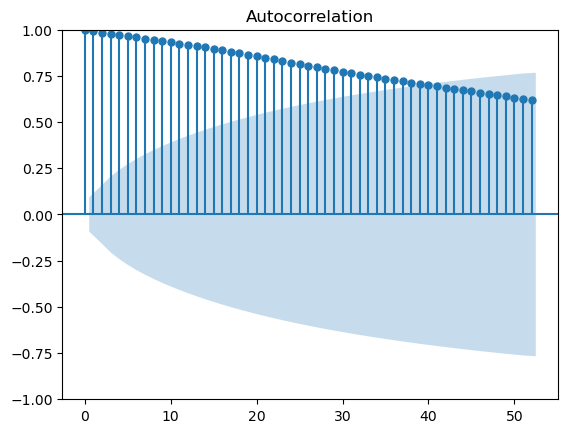

In [19]:
fig = tsaplots.plot_acf(df_weekly["y"],lags=52)

### Hyperparameter optimizer

In [20]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import optuna
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric

In [116]:
def objective(trial):
    interval_width = trial.suggest_float('interval_width', 0.8, 0.99)
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.01, 0.8)
    n_changepoints = trial.suggest_int('n_changepoints', 10, 30)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 8.00, 20.0)
    fourier_order = trial.suggest_int('fourier_order', 1, 20)
    
    
    model = Prophet(
        interval_width=interval_width,
        changepoint_prior_scale=changepoint_prior_scale,
        n_changepoints=n_changepoints,
        weekly_seasonality=True,
        seasonality_mode=seasonality_mode,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
    )
    
    model.add_seasonality(name='yearly', period=30.5, fourier_order=fourier_order)

    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=len(test_data), freq='W')
    forecast = model.predict(future)
    
    forecast_valid = forecast[forecast['ds'].isin(test_data['ds'])]
    
    y_true = test_data['y'].values
    y_pred = forecast_valid['yhat'].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return rmse

In [23]:
## Split data
train_data = df_weekly[df_weekly['ds'] < '2022-01-01']
test_data = df_weekly[df_weekly['ds'] >= '2022-01-01']

train_data = train_data.loc[:, ['ds', 'y']]
test_data = test_data.loc[:, ['ds', 'y']]

print("Train data size:")
print(train_data.shape[0])
print("\nTest data size:")
print(test_data.shape[0])

Train data size:
365

Test data size:
84


#### *** No es necesario ejecutar optuna de nuevo ya que deje los hiperparámetros en una variable

In [117]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-05-30 02:57:40,611] A new study created in memory with name: no-name-fb9098c5-c3fe-4654-8829-447ec1455802
02:57:40 - cmdstanpy - INFO - Chain [1] start processing
02:57:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-05-30 02:57:40,818] Trial 0 finished with value: 92.38601267011232 and parameters: {'interval_width': 0.9753407305666127, 'changepoint_prior_scale': 0.16680462760327672, 'n_changepoints': 17, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.856796815480806, 'holidays_prior_scale': 10.193768541242163, 'fourier_order': 4}. Best is trial 0 with value: 92.38601267011232.
02:57:40 - cmdstanpy - INFO - Chain [1] start processing
02:57:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-05-30 02:57:41,090] Trial 1 finished with value: 90.94741589155639 and parameters: {'interval_width': 0.9249177422269369, 'changepoint_prior_scale': 0.10579880772800257, 'n_changepoints': 19, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.778912670

In [118]:
best_params = study.best_params
print('Best Metric: ', study.best_value)
print('Best params: ', study.best_params)

Best Metric:  58.536885003350264
Best params:  {'interval_width': 0.8949954517700941, 'changepoint_prior_scale': 0.0109953376690951, 'n_changepoints': 24, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.547806237038662, 'holidays_prior_scale': 19.35300631846166, 'fourier_order': 9}


In [28]:
## Para no volver a correr el optimizador, se guardan los mejores parámetros
best_params = {'interval_width': 0.8949954517700941, 'changepoint_prior_scale': 0.0109953376690951, 'n_changepoints': 24, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.547806237038662, 'holidays_prior_scale': 19.35300631846166, 'fourier_order': 9}

### Prophet training

In [24]:
## entrenamos el modelo con los best params
combined_data = pd.concat([train_data, test_data]).reset_index(drop=True)

model = Prophet(
    interval_width=best_params['interval_width'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    n_changepoints=best_params['n_changepoints'],
    weekly_seasonality=True,
    seasonality_mode=best_params['seasonality_mode'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale']
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['fourier_order'])
model.fit(combined_data)

22:53:47 - cmdstanpy - INFO - Chain [1] start processing
22:53:47 - cmdstanpy - INFO - Chain [1] done processing


### Prophet evaluation

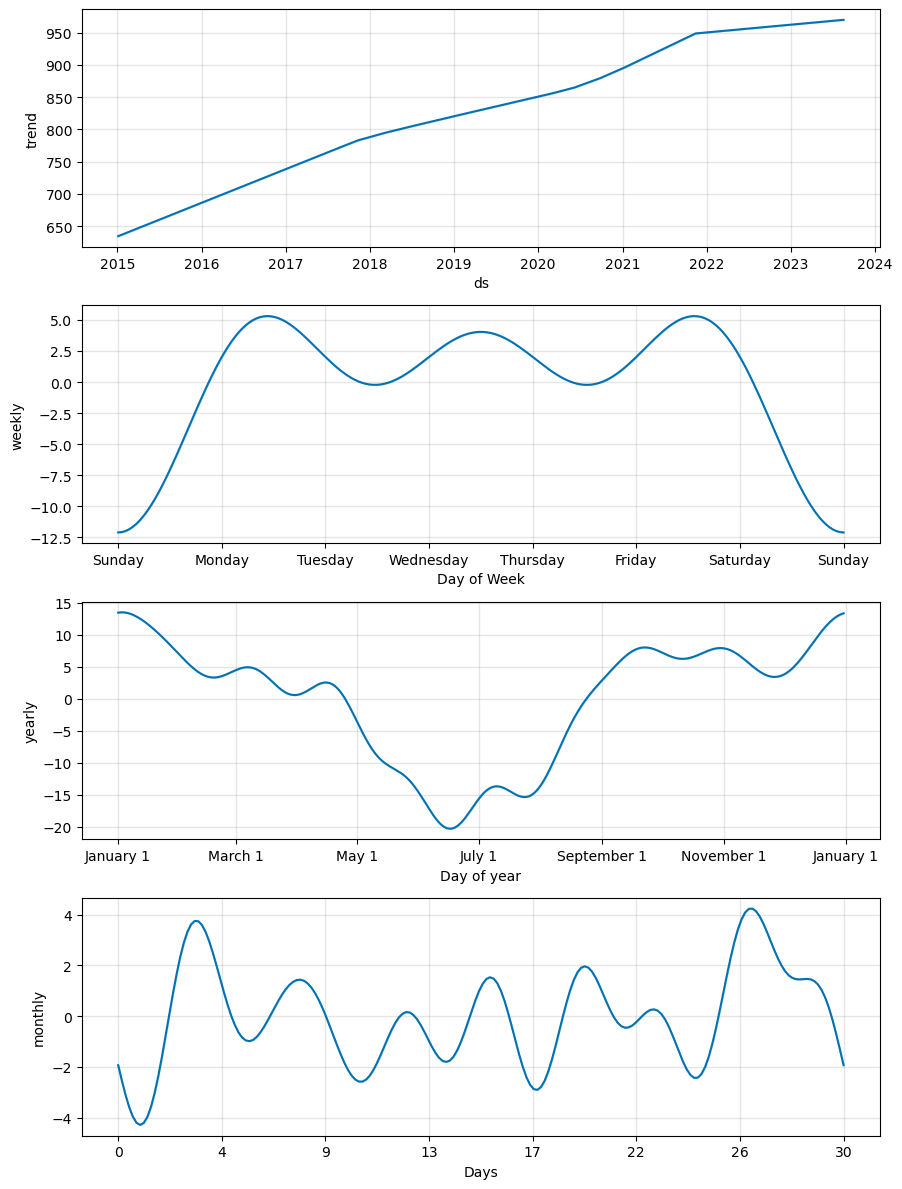

In [31]:
future = model.make_future_dataframe(periods=12)
forecast = model.predict(future)
fig = model.plot_components(forecast)

In [25]:
df_cv = cross_validation(model, 
                         initial=f'{104 * 7} days',  #  2 años
                         period=f'{4 * 7} days',     # por mes
                         horizon=f'{52 * 7} days')   # 1 año
df_cv

  0%|          | 0/74 [00:00<?, ?it/s]

22:53:50 - cmdstanpy - INFO - Chain [1] start processing
22:53:50 - cmdstanpy - INFO - Chain [1] done processing
22:53:50 - cmdstanpy - INFO - Chain [1] start processing
22:53:50 - cmdstanpy - INFO - Chain [1] done processing
22:53:50 - cmdstanpy - INFO - Chain [1] start processing
22:53:50 - cmdstanpy - INFO - Chain [1] done processing
22:53:50 - cmdstanpy - INFO - Chain [1] start processing
22:53:50 - cmdstanpy - INFO - Chain [1] done processing
22:53:50 - cmdstanpy - INFO - Chain [1] start processing
22:53:50 - cmdstanpy - INFO - Chain [1] done processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing
22:53:51 - cmdstanpy - INFO - Chain [1] done processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing
22:53:51 - cmdstanpy - INFO - Chain [1] done processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing
22:53:51 - cmdstanpy - INFO - Chain [1] done processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing
22:53:51 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-08,732.889732,725.887015,740.121132,730.504586,2017-01-01
1,2017-01-15,731.384354,723.907917,739.047837,725.766069,2017-01-01
2,2017-01-22,732.956922,725.550676,740.258046,717.353454,2017-01-01
3,2017-01-29,739.579254,732.132755,746.593222,714.414817,2017-01-01
4,2017-02-05,741.949694,734.631665,749.365053,710.849518,2017-01-01
...,...,...,...,...,...,...
3843,2023-07-09,1062.481829,1037.818987,1089.725558,904.871792,2022-08-07
3844,2023-07-16,1068.903979,1042.464339,1094.552701,918.623411,2022-08-07
3845,2023-07-23,1067.013323,1042.084817,1091.804336,919.283957,2022-08-07
3846,2023-07-30,1068.024772,1041.675872,1094.163312,917.182048,2022-08-07


In [26]:
df_p = performance_metrics(df_cv)


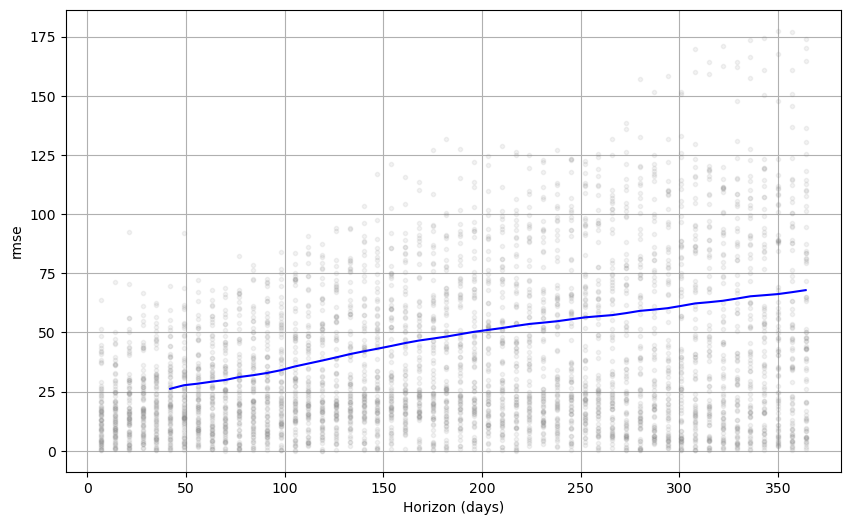

In [27]:
fig = plot_cross_validation_metric(df_cv, metric="rmse")

In [33]:
## save model
import joblib
joblib.dump(model, 'prophet_model.pkl')


['prophet_model.pkl']